# Libs

In [1]:
import time
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from bernstein_flow.activations import get_thetas_constrain_fn
from bernstein_flow.bijectors import BernsteinBijectorLinearExtrapolate
from bernstein_flow.distributions import BernsteinFlow
from bernstein_flow.util.visualization import plot_flow
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras as K
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability.python.internal import (
    dtype_util,
    prefer_static,
    tensor_util,
)

2023-04-18 13:41:30.743713: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print(np.__version__)
print(pd.__version__)
print(sns.__version__)
print(tf.__version__)
print(tfp.__version__)

1.24.2
1.5.3
0.12.2
2.9.3
0.16.0


In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Seed

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Functions

In [5]:
# Construct and fit model.
# @tf.function
def fit_distribution(
    model,
    learning_rate=0.001,
    lr_patience=5,
    loss=lambda y, dist: -dist.log_prob(y),
    **kwds,
):
    set_seed(1)
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        loss=loss,
    )

    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=lr_patience,
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3 * lr_patience,
            restore_best_weights=True,
        ),
        tf.keras.callbacks.TerminateOnNaN(),
    ]

    return model.fit(
        shuffle=True,
        callbacks=callbacks,
        **kwds,
    )

In [6]:
def plot_grid(data, **kwds):
    sns.set_theme(style="white")

    g = sns.PairGrid(data, diag_sharey=False, **kwds)
    g.map_upper(sns.scatterplot, s=15)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot, lw=2)
    return g

In [7]:
def plot_samples_grid(samples, train_data, **kwds):
    df = samples.assign(model=True)
    df = df.append(train_data.sample(len(df)).assign(model=False))

    g = plot_grid(df, hue="model", **kwds)
    g = g.add_legend()
    return g

# Data

In [8]:
data = pd.read_csv("india.raw", sep="\s+")

In [9]:
targets = ["stunting", "wasting", "underweight"]
covariates = data.columns[~data.columns.isin(targets)].to_list()

In [10]:
test_size = 0.1
val_size = 0.1

In [11]:
set_seed(1)
train_val_data, test_data = train_test_split(data, test_size=test_size, shuffle=True)
train_data, val_data = train_test_split(
    train_val_data, test_size=val_size, shuffle=True
)
del train_val_data, data

In [12]:
ct = make_column_transformer(
    (MinMaxScaler(), targets),
    remainder=StandardScaler(),
    verbose_feature_names_out=False,
)
ct.set_output(transform="pandas")

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['stunting', 'wasting', 'underweight'])],
                  verbose_feature_names_out=False)

In [13]:
train_data_scaled = ct.fit_transform(train_data)
val_data_scaled = ct.transform(val_data)
test_data_scaled = ct.transform(test_data)

In [14]:
assert train_data_scaled.index.isin(test_data_scaled.index).any() == False
assert train_data_scaled.index.isin(val_data_scaled.index).any() == False
assert val_data_scaled.index.isin(test_data_scaled.index).any() == False

In [15]:
t = partial(tf.convert_to_tensor, dtype=tf.float32)

In [16]:
train_x, train_y = t(train_data_scaled[covariates]), t(train_data_scaled[targets])
val_x, val_y = t(val_data_scaled[covariates]), t(val_data_scaled[targets])
test_x, test_y = t(test_data_scaled[covariates]), t(test_data_scaled[targets])

2023-04-18 13:41:32.646635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 13:41:33.160586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22101 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:17:00.0, compute capability: 7.5


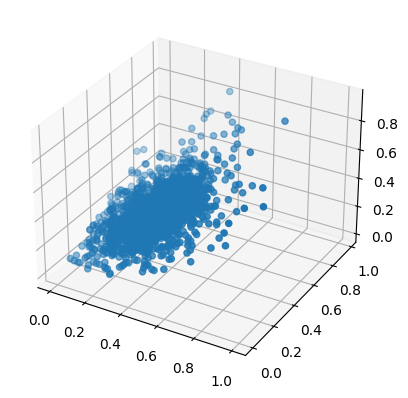

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*train_data_scaled[targets].sample(frac=0.1).values.T)

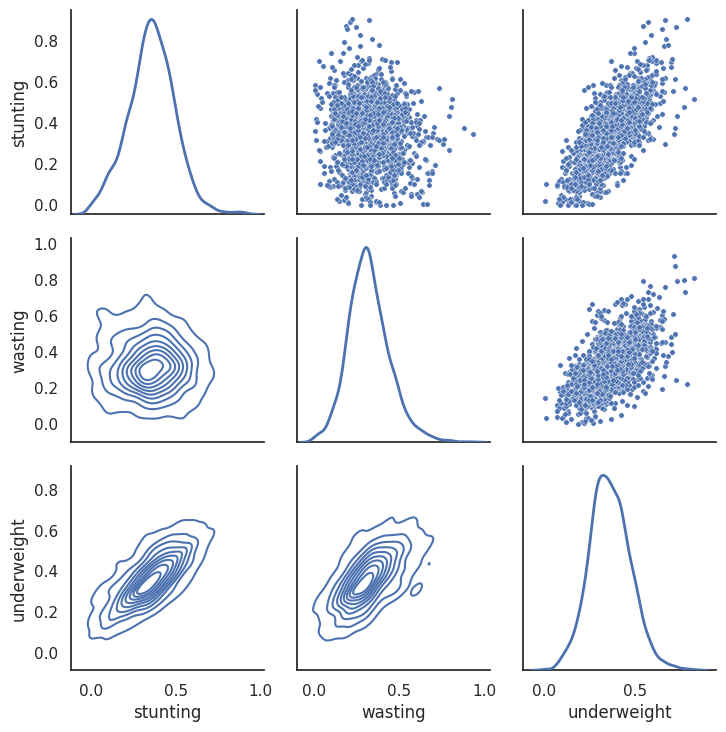

In [18]:
plot_grid(train_data_scaled[targets].sample(frac=0.1))

# Models

In [19]:
dims = len(targets)

## Parameter Model

In [20]:
def get_model(input_shape, output_shape, dist_lambda):
    set_seed(1)
    inputs = K.Input(input_shape)
    x = K.layers.Dense(32, activation="relu", name="hidden1")(inputs)
    x = K.layers.Dense(32, activation="relu", name="hidden2")(x)
    pv = K.layers.Dense(output_shape, activation="linear", name="pv")(x)
    dist = tfp.layers.DistributionLambda(dist_lambda)(pv)
    param_model = K.Model(inputs=inputs, outputs=dist)
    param_model.summary()
    return param_model

In [21]:
P = partial(get_model, input_shape=len(covariates))

## Multivariate Normal

In [22]:
def get_multivariate_normal_lambda(dims):
    def lmbd(pv):
        loc = pv[..., :dims]
        scale_tril = tfp.bijectors.FillScaleTriL()(pv[..., dims:])
        mv_normal = tfd.MultivariateNormalTriL(loc=loc, scale_tril=scale_tril)
        return mv_normal

    return lmbd

In [23]:
mn_model = P(
    output_shape=dims + np.sum(np.arange(dims + 1)),
    dist_lambda=get_multivariate_normal_lambda(dims),
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 hidden1 (Dense)             (None, 32)                1312      
                                                                 
 hidden2 (Dense)             (None, 32)                1056      
                                                                 
 pv (Dense)                  (None, 9)                 297       
                                                                 
 distribution_lambda (Distri  ((None, 3),              0         
 butionLambda)                (None, 3))                         
                                                                 
Total params: 2,665
Trainable params: 2,665
Non-trainable params: 0
___________________________________________________________

In [24]:
mn_hist = fit_distribution(
    mn_model,
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=32,
    epochs=100,
    # steps_per_epoch=2,
    learning_rate=0.01,
    lr_patience=2,
)

Epoch 1/100
  9/615 [..............................] - ETA: 4s - loss: 7.7683    

2023-04-18 13:41:39.823099: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x5606781613d0


615/615 [==============================] - 6s 8ms/step - loss: -1.0021 - val_loss: -3.1314 - lr: 0.0100
Epoch 2/100
615/615 [==============================] - 4s 7ms/step - loss: -3.4654 - val_loss: -4.2106 - lr: 0.0100
Epoch 3/100
615/615 [==============================] - 4s 7ms/step - loss: -2.6123 - val_loss: -3.4129 - lr: 0.0100
Epoch 4/100
615/615 [==============================] - 5s 7ms/step - loss: -4.3258 - val_loss: -5.4507 - lr: 0.0100
Epoch 5/100
615/615 [==============================] - 5s 7ms/step - loss: -5.3738 - val_loss: -5.2249 - lr: 0.0100
Epoch 6/100
615/615 [==============================] - 5s 7ms/step - loss: -5.5922 - val_loss: -5.8437 - lr: 0.0100
Epoch 7/100
615/615 [==============================] - 4s 7ms/step - loss: -5.8167 - val_loss: -6.0759 - lr: 0.0100
Epoch 8/100
615/615 [==============================] - 5s 7ms/step - loss: -5.8655 - val_loss: -5.9635 - lr: 0.0100
Epoch 9/100
615/615 [==============================] - 4s 7ms/step - loss: -5.9320 -

In [25]:
mn_samples = mn_model(val_x).sample(10)
mn_samples.shape

TensorShape([10, 2186, 3])

In [26]:
df = pd.DataFrame(mn_samples.numpy().reshape([-1, 3]), columns=targets)

/tmp/ipykernel_7175/2899264846.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(train_data.sample(len(df)).assign(model=False))


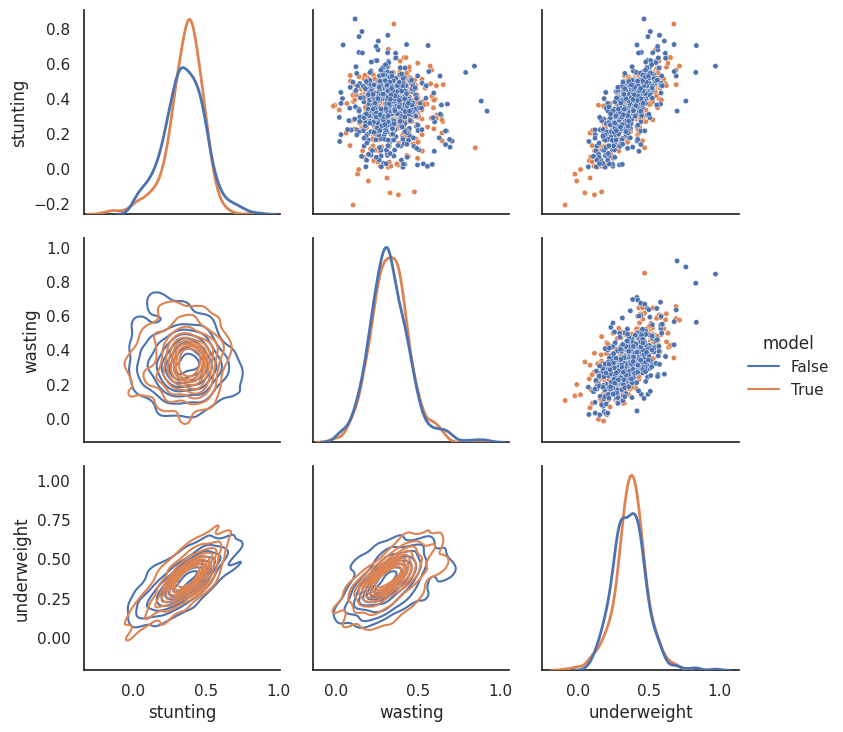

In [27]:
plot_samples_grid(df.sample(500), train_data_scaled[targets])

## Multivariate Conditional Transformation Models

the model-based density function for $Y$ is therefore

$f_{\boldsymbol{Y}}(\boldsymbol{y})=\prod_{j=1}^{J} \phi_{0,1}\left(\lambda_{j 1} \tilde{h}_{1}\left(y_{1}\right)+\ldots+\lambda_{j, j-1} \tilde{h}_{j-1}\left(y_{j-1}\right)+\tilde{h}_{j}\left(y_{j}\right)\right) \frac{\partial \tilde{h}_{j}\left(y_{j}\right)}{\partial y_{j}}$

Summarising the model's specifications, our multivariate transformation model is characterised by a set of marginal transformations $\tilde{h}_{j}\left(y_{j}\right), j=1, \ldots, J$, each applying to only a single component of the vector $\boldsymbol{Y}$, and by a lower triangular $(J \times J)$ matrix of transformation coefficients

$\boldsymbol{\Lambda}=\left(\begin{array}{ccccc}1 & & & & 0 \\ \lambda_{21} & 1 & & & \\ \lambda_{31} & \lambda_{32} & 1 & & \\ \vdots & \vdots & & \ddots & \\ \lambda_{J 1} & \lambda_{J 2} & \ldots & \lambda_{J, J-1} & 1\end{array}\right)$

For the transformation functions $\tilde{h}_{j}$, the explicit representation
$$
\tilde{h}_{j}\left(Y_{j}\right)=\Phi_{0, \sigma_{j}^{2}}^{-1}\left(F_{j}\left(Y_{j}\right)\right)=\tilde{Z}_{j}
$$
is obtained, where $F_{j}(\cdot)$ is the univariate marginal CDF of $Y_{j}$. In summary,
$$
\begin{aligned}
\mathbb{P}(\boldsymbol{Y} \leq \boldsymbol{y}) &=\mathbb{P}(\tilde{\boldsymbol{Z}} \leq \tilde{\boldsymbol{z}})=\Phi_{0, \boldsymbol{\Sigma}}(\tilde{\boldsymbol{z}})=\Phi_{\mathbf{0}, \boldsymbol{\Sigma}}\left[\Phi_{0, \sigma_{1}^{2}}^{-1}\left\{F_{1}\left(y_{1}\right)\right\}, \ldots, \Phi_{0, \sigma_{J}^{2}}^{-1}\left\{F_{J}\left(y_{J}\right)\right\}\right] \\
&=\Phi_{0, \boldsymbol{\Sigma}}\left(\tilde{h}_{1}\left(y_{1}\right), \ldots, \tilde{h}_{J}\left(y_{J}\right)\right)
\end{aligned}
$$
and therefore the CDF of $\boldsymbol{Y}$ has exactly the same structure as a Gaussian copula, except that our representation relies on a different parameterisation of $\boldsymbol{\Sigma}$ through $\boldsymbol{\Sigma}=\Lambda^{-1} \Lambda^{-\top}$.

In [28]:
def get_mctm_lambda(dims, M, thetas_constrain_fn):
    def lmbd(pv):
        bs = prefer_static.shape(pv)[:-1]
        shape = tf.concat((bs, [dims, M]), 0)

        thetas = thetas_constrain_fn(tf.reshape(pv[..., : M * dims], shape))
        scale_tril = tfp.bijectors.FillScaleTriL()(pv[..., M * dims :])

        mv_normal = tfd.MultivariateNormalTriL(loc=0, scale_tril=scale_tril)

        return tfd.TransformedDistribution(
            distribution=mv_normal,
            bijector=tfb.Invert(BernsteinBijectorLinearExtrapolate(thetas=thetas)),
        )

    return lmbd

In [73]:
thetas_constrain_fn = get_thetas_constrain_fn(
    low=-3,
    high=3,
    smooth_bounds=True,
    allow_flexible_bounds=True,
    fn=tf.math.softplus,
    eps=1e-04,
)

In [30]:
M = 20
output_shape = dims * M + np.sum(np.arange(dims + 1))

In [31]:
d = get_mctm_lambda(dims, M, thetas_constrain_fn)(tf.ones((output_shape)))

In [32]:
tfp.layers.DistributionLambda(get_mctm_lambda(dims, M, thetas_constrain_fn))(
    tf.ones((output_shape))
)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[] event_shape=[3] dtype=float32>

In [33]:
mctm_model = P(
    output_shape=output_shape, dist_lambda=get_mctm_lambda(dims, M, thetas_constrain_fn)
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40)]              0         
                                                                 
 hidden1 (Dense)             (None, 32)                1312      
                                                                 
 hidden2 (Dense)             (None, 32)                1056      
                                                                 
 pv (Dense)                  (None, 66)                2178      
                                                                 
 distribution_lambda_2 (Dist  ((None, 3),              0         
 ributionLambda)              (None, 3))                         
                                                                 
Total params: 4,546
Trainable params: 4,546
Non-trainable params: 0
_________________________________________________________

In [34]:
mctm_hist = fit_distribution(
    mctm_model,
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=32,
    epochs=100,
    # steps_per_epoch=2,
    learning_rate=0.01,
    lr_patience=2,
)

Epoch 1/100
615/615 [==============================] - 11s 14ms/step - loss: -5.8122 - val_loss: -7.2291 - lr: 0.0100
Epoch 2/100
615/615 [==============================] - 8s 13ms/step - loss: -7.9345 - val_loss: -7.9744 - lr: 0.0100
Epoch 3/100
615/615 [==============================] - 8s 13ms/step - loss: -8.5105 - val_loss: -8.4928 - lr: 0.0100
Epoch 4/100
615/615 [==============================] - 8s 13ms/step - loss: -8.8418 - val_loss: -8.9664 - lr: 0.0100
Epoch 5/100
615/615 [==============================] - 8s 13ms/step - loss: -8.9738 - val_loss: -8.9565 - lr: 0.0100
Epoch 6/100
615/615 [==============================] - 8s 13ms/step - loss: -9.1548 - val_loss: -9.1360 - lr: 0.0100
Epoch 7/100
615/615 [==============================] - 8s 13ms/step - loss: -9.2791 - val_loss: -9.0681 - lr: 0.0100
Epoch 8/100
615/615 [==============================] - 8s 13ms/step - loss: -9.3771 - val_loss: -9.4431 - lr: 0.0100
Epoch 9/100
615/615 [==============================] - 8s 13ms/

In [35]:
mctm_samples = mctm_model(val_x).sample(10)
mctm_samples.shape

TensorShape([10, 2186, 3])

In [36]:
df = pd.DataFrame(mctm_samples.numpy().reshape([-1, 3]), columns=targets)

/tmp/ipykernel_7175/2899264846.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(train_data.sample(len(df)).assign(model=False))


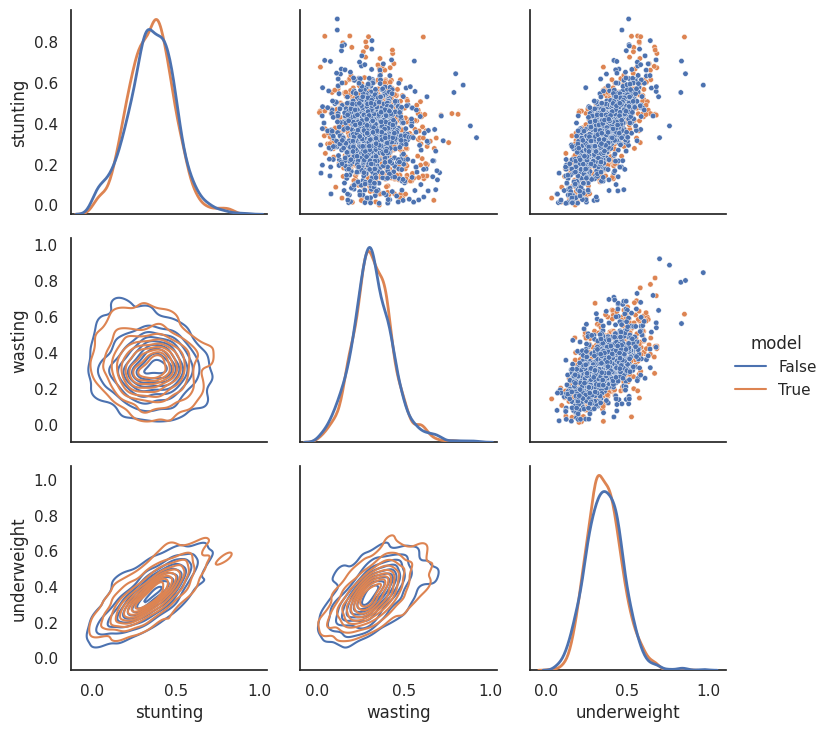

In [37]:
plot_samples_grid(df.sample(1000), train_data_scaled[targets])

step = 0.01
xi, yi, zi = np.mgrid[0:1:step, 0:1:step, 0:1:step]
grid = np.stack([xi.flatten(), yi.flatten(), zi.flatten()], 1)

grid.shape

val_x.numpy().mean(-1)

d = mctm_model(val_x.numpy().mean(0)[None, ...]).prob(grid).numpy()
d.shape

#%matplotlib notebook

import matplotlib
ax = plt.figure().add_subplot(projection="3d")
surf = ax.scatter(
    xi,
    yi,
    zi,
    #c=d / d.max(),
    alpha=d / d.max(),
    cmap=matplotlib.cm.viridis,
    antialiased=False,
)

img=d.reshape(xi.shape)

plt.imshow(img[0])

from ipywidgets import interact

@interact(i=(0, zi.shape[0]))
def g(i):
    plt.imshow(img[i])

## MADE + BNF
https://github.com/tensorchiefs/bfvi/blob/main/R/multidimensional_script.R

In [38]:
def get_bijector_fn(made, thetas_constrain_fn):
    def bijector_fn(x, **kwds):
        with tf.name_scope("bnf_made_bjector"):
            dtype = made.dtype

            pvector = made(x, **kwds)
            thetas = thetas_constrain_fn(pvector)

            return tfb.Invert(BernsteinBijectorLinearExtrapolate(thetas=thetas))

    return bijector_fn

In [39]:
from functools import partial


class ConditionedDistribution:
    def __init__(self, dist, conditional_input):
        self.distribution = dist
        self.conditional_input = conditional_input
        for m in ["prob", "log_prob", "sample"]:
            setattr(
                self,
                m,
                partial(
                    getattr(dist, m),
                    bijector_kwargs={"conditional_input": self.conditional_input},
                ),
            )
        self.dtype = dist.dtype

In [40]:
class ConditionedDistributionModel(tf.keras.models.Model):
    def __init__(
        self, distribution, extra_variables
    ):  # ** additional arguments for the super class
        super().__init__()
        self.distribution = distribution
        self.extra_variables = extra_variables

    def call(self, x):
        return ConditionedDistribution(self.distribution, x)

In [74]:
set_seed(1)
event_shape = (dims,)
conditional_event_shape = (len(covariates),)

made = tfb.AutoregressiveNetwork(
    params=M,
    hidden_units=[32, 32],
    activation="relu",
    event_shape=event_shape,
    conditional=True,
    # conditional_input_layers='first_layer',
    conditional_event_shape=conditional_event_shape,
)
made.build(event_shape)
# thetas_constrain_fn = get_thetas_constrain_fn(low=-4, high=4, smooth_bounds=True)
bijector_fn = get_bijector_fn(made=made, thetas_constrain_fn=thetas_constrain_fn)
ar_mctm = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(0, 1), sample_shape=[dims]),
    bijector=tfb.MaskedAutoregressiveFlow(bijector_fn=bijector_fn),
)

In [75]:
ar_mctm_model = ConditionedDistributionModel(ar_mctm, made.trainable_variables)
ar_mctm_hist = fit_distribution(
    ar_mctm_model,
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=32,
    epochs=100,
    # steps_per_epoch=2,
    learning_rate=0.01,
    lr_patience=2,
)

Epoch 1/100
615/615 [==============================] - 11s 15ms/step - loss: -6.2660 - val_loss: -7.7208 - lr: 0.0100
Epoch 2/100
615/615 [==============================] - 9s 14ms/step - loss: -8.1352 - val_loss: -8.5079 - lr: 0.0100
Epoch 3/100
615/615 [==============================] - 9s 14ms/step - loss: -8.5894 - val_loss: -8.5732 - lr: 0.0100
Epoch 4/100
615/615 [==============================] - 9s 14ms/step - loss: -8.8140 - val_loss: -8.8968 - lr: 0.0100
Epoch 5/100
615/615 [==============================] - 9s 14ms/step - loss: -9.0133 - val_loss: -8.8820 - lr: 0.0100
Epoch 6/100
615/615 [==============================] - 9s 14ms/step - loss: -9.1807 - val_loss: -8.7207 - lr: 0.0100
Epoch 7/100
615/615 [==============================] - 9s 14ms/step - loss: -9.8902 - val_loss: -9.8562 - lr: 1.0000e-03
Epoch 8/100
615/615 [==============================] - 9s 14ms/step - loss: -10.0660 - val_loss: -9.9416 - lr: 1.0000e-03
Epoch 9/100
615/615 [==============================] -

from tqdm.notebook import trange

epochs = 500
learning_rate = 0.01
decay_rate = 0.1

set_seed(1)

opt = tf.optimizers.Adam(learning_rate)

it = trange(epochs)
for i in it:
    nll = lambda: -ar_mctm.log_prob(
        train_y, bijector_kwargs={"conditional_input": train_x}
    )
    opt.minimize(nll, var_list=made.trainable_variables)
    it.set_postfix(loss=nll().numpy().mean(), lr=opt.learning_rate.numpy())

In [77]:
ar_mctm_samples = ar_mctm.sample((10, 1), bijector_kwargs={"conditional_input": val_x})
ar_mctm_samples.shape

TensorShape([10, 2186, 3])

In [78]:
df = pd.DataFrame(ar_mctm_samples.numpy().reshape([-1, 3]), columns=targets)

/tmp/ipykernel_7175/2899264846.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(train_data.sample(len(df)).assign(model=False))


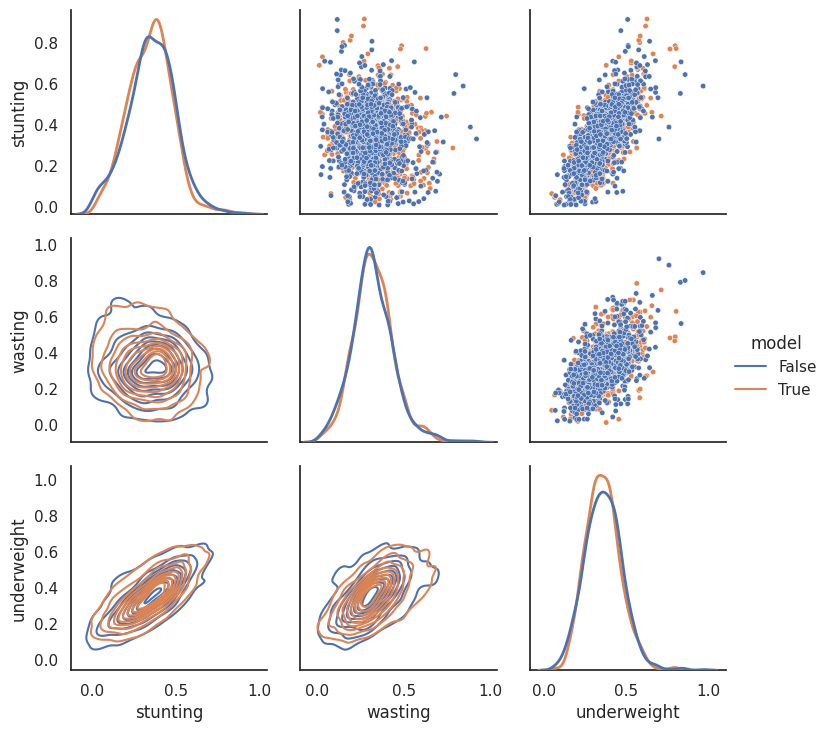

In [79]:
plot_samples_grid(df.sample(1000), train_data_scaled[targets])

# Results

<Axes: >

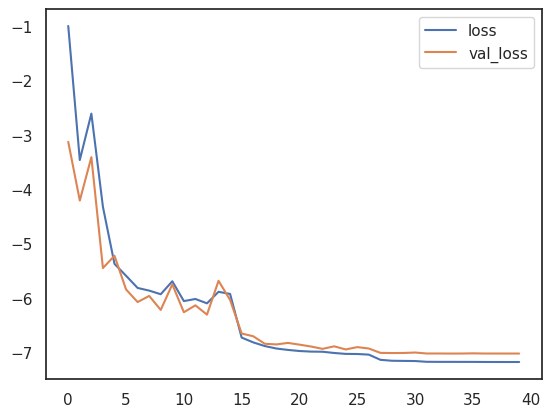

In [68]:
pd.DataFrame(mn_hist.history)[["loss", "val_loss"]].plot()

<Axes: >

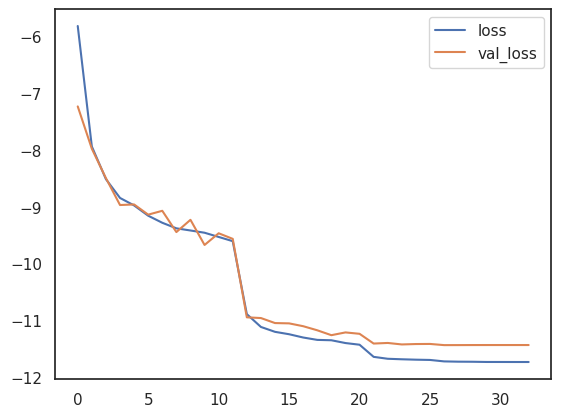

In [69]:
pd.DataFrame(mctm_hist.history)[["loss", "val_loss"]].plot()

<Axes: >

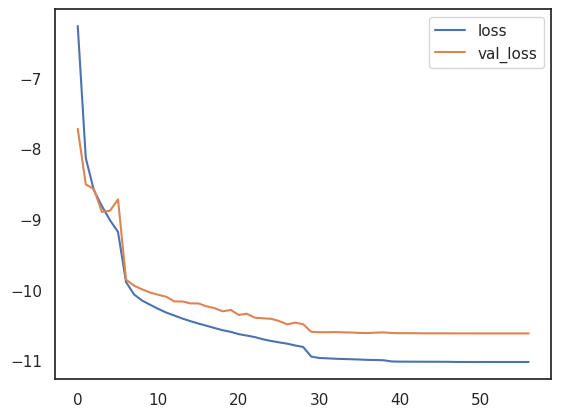

In [80]:
pd.DataFrame(ar_mctm_hist.history)[["loss", "val_loss"]].plot()